# Import Libraries

In [1]:
#+---- Basic Libraries ----+#
import sys, os, time, gc, random
from pathlib import Path
import pandas as pd
import numpy as np
import copy
from utils import *

#+---- Utilities Libraries ----+#
#import albumentations as albu
import pretrainedmodels
from efficientnet_pytorch import EfficientNet
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from PIL import Image
from tqdm.notebook import tqdm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

#+---- Pytorch Libraries ----+#
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import model_zoo
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

#+---- List the input data ----+#
for dirname, _, filenames in os.walk('../../input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../../input/train.csv
../../input/test.csv
../../input/class_map.csv
../../input/.gitkeep
../../input/sample_submission.csv
../../input/parquet/train_image_data_2.parquet
../../input/parquet/test_image_data_2.parquet
../../input/parquet/train_image_data_3.parquet
../../input/parquet/test_image_data_1.parquet
../../input/parquet/test_image_data_0.parquet
../../input/parquet/test_image_data_3.parquet
../../input/parquet/train_image_data_0.parquet
../../input/parquet/train_image_data_1.parquet
../../input/feather/train_image_data_2.feather
../../input/feather/test_image_data_1.feather
../../input/feather/train_image_data_1.feather
../../input/feather/test_image_data_3.feather
../../input/feather/train_image_data_0.feather
../../input/feather/test_image_data_0.feather
../../input/feather/test_image_data_2.feather
../../input/feather/train_image_data_3.feather


# Initial Settings

## Directories

In [2]:
DATADIR = Path('../../input')
FEATHERDIR = Path('../../input/feather')
OUTDIR = Path('../../output')

In [3]:
os.listdir('../../')

['input', '.gitignore', 'README.md', '.git', 'src', 'submission', 'output']

## Learning Parameters

In [34]:
DEBUG =False
SUBMISSION =False
BATCH_SIZE =64
NUM_EPOCH = 36
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MDL_DIR = '../models'
LOG_DIR = '../logs'
IMAGE_SIZE=128
TRAIN_RATIO = 0.9
WORKER = 4
SEED = 6666
MODEL_NAME ='efficientnet-b4'
N_Fold = 10
CV = True
Fold = 1
PATIAENCE = 4
VER = 'fold_1_mixup'

In [5]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

# Dataset

## Transform class for data preprocessing and augmentations

In [6]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [7]:
def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

In [8]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.RandomAffine(degrees=0.6),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
    ]),
    'val': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [9]:
class BengaliAIDataset(Dataset):
    def __init__(self, images, labels=None, transform=None, indices=None):
        self.transform = transform
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)
      
    def __getitem__(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) #/ 255.
        x = crop_char_image(x)
        x = Image.fromarray(x).convert("RGB")
        x = self.transform(x)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

## Import Data

In [10]:
train = pd.read_csv(DATADIR/'train.csv')
train['id'] = train['image_id'].apply(lambda x: int(x.split('_')[1]))
X, y = train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train.values[:,1:]
train['fold'] = np.nan
mskf = MultilabelStratifiedKFold(n_splits=N_Fold)
for i, (_, index) in enumerate(mskf.split(X, y)):
    print('Fold '+str(i+1))
    train.iloc[index, -1] = i
train['fold'] = train['fold'].astype('int')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [11]:
%%time
#train = pd.read_csv(DATADIR/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if DEBUG else [0, 1, 2, 3]
train_images = prepare_image(
    DATADIR, FEATHERDIR, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 9.25 s, sys: 12 s, total: 21.3 s
Wall time: 12.1 s


In [12]:
n_dataset = len(train_images)

if not CV:
    train_data_size = 200 if DEBUG else int(n_dataset * TRAIN_RATIO)
    valid_data_size = 100 if DEBUG else int(n_dataset - train_data_size)
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)

    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['train'],
        indices=perm[:train_data_size])

    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['val'],
        indices=perm[train_data_size:train_data_size+valid_data_size])
else:
    valid_idx = np.array(train[train['fold']==Fold].index)
    trn_idx = np.array(train[train['fold']!=Fold].index)
    trn_idx = trn_idx[:200] if DEBUG else trn_idx
    valid_idx = valid_idx[:100] if DEBUG else valid_idx
    
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['train'],
        indices=trn_idx)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['val'],
        indices=valid_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKER)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKER)

dataloaders = {'train':train_loader, 'val': valid_loader}
dataset_sizes = {'train':len(train_dataset), 'val': len(valid_dataset)}

In [13]:
image, label = train_dataset[1]
print('image', image.shape, 'label', label)

image torch.Size([3, 128, 128]) label [159   0   0]


# Define Model/Train functions

In [14]:
def ohem_loss(rate, cls_pred, cls_target):
    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss

In [51]:
def macro_recall(pred_labels, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(y[1],pred_labels[1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
           f'total {final_score}')
    return final_score

In [52]:
def get_pred(preds_list, label_list):
    #preds_list is torch tensor to device
    #label_list is torch tensor to device
    _, pred0 = torch.max(preds_list[0], 1)
    _, pred1 = torch.max(preds_list[1], 1)
    _, pred2 = torch.max(preds_list[2], 1)
    p0 = pred0.cpu().numpy()
    p1 = pred1.cpu().numpy()
    p2 = pred2.cpu().numpy()
    pred_labels = [p0, p1, p2]
    #print(pred_labels)
    a0 = label_list[0].cpu().numpy()
    a1 = label_list[1].cpu().numpy()
    a2 = label_list[2].cpu().numpy() 
    y = [a0, a1, a2]
    #print(y)
    return pred_labels, y

In [17]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, \
               shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3,\
               shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1],\
    targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) +\
lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) +\
lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], \
    targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2)\
+ lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) +\
lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [77]:
def train_model(model, dataloaders, criterion, optimizer, scheduler,start_epoch,
                num_epochs, device, patiance):
    since = time.time()
    
    trn_loss_list =[]
    trn_acc_list = []
    val_loss_list =[]
    val_acc_list = []
    epoch_list = []
    recall_list = []
    mix_cnt = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10
    torch.backends.cudnn.benchmark = True
    early_stopping_counter = 0
    
    for epoch in range(num_epochs)[start_epoch:]:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)  
        
        if early_stopping_counter == patiance:
            print(f'Early Stopped since loss have not decreased for {patiance} epoch.')
            break
        epoch_list.append(epoch+1)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss = 0.0
            epoch_corrects = 0
            dataset_sizes = len(dataloaders[phase].dataset)
            length = int(np.floor(dataset_sizes/BATCH_SIZE))
            mixuplist = random.sample( range(length), int(0.2*length))

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(tqdm(dataloaders[phase])):
                #print(inputs.shape)
                inputs = inputs.to(device)
                labels = labels.transpose(1,0).to(device) #use when single label for one image

                grapheme_root = labels[0]
                vowel_diacritic = labels[1]
                consonant_diacritic = labels[2]
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):                                 
                    if phase == 'train':
                        if idx in mixuplist:
                            mix_cnt += 1
                            inputs_mixed, labels_mixed = mixup(inputs, grapheme_root, \
                                                               vowel_diacritic, consonant_diacritic, 0.1)

                            outputs = model(inputs_mixed) 
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = mixup_criterion(grapheme_root_prd,vowel_diacritic_prd,\
                                               consonant_diacritic_prd, labels_mixed)
                        
                        else:
                            outputs = model(inputs)
                            grapheme_root_prd = outputs[0]
                            vowel_diacritic_prd = outputs[1]
                            consonant_diacritic_prd = outputs[2]
                            loss = (1/4)*(2*criterion(grapheme_root_prd, grapheme_root)+\
                                  criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                     criterion(consonant_diacritic_prd, consonant_diacritic))
                        loss.backward()
                        optimizer.step()
                    if phase == 'val':
                        outputs = model(inputs)
                        grapheme_root_prd = outputs[0]
                        vowel_diacritic_prd = outputs[1]
                        consonant_diacritic_prd = outputs[2]
                        loss = (1/4)*(2*criterion(grapheme_root_prd, grapheme_root)+\
                              criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                 criterion(consonant_diacritic_prd, consonant_diacritic))
                        #scheduler.step()
                        # if plateau scheduler use following
                        
                # statistics: inputs.size(0) is batch size
                epoch_loss += loss.item() * inputs.size(0) # total loss for this batch
                epoch_corrects += torch.sum(torch.max(outputs[0], 1)[1] == labels[0])+\
                    torch.sum(torch.max(outputs[1], 1)[1] == labels[1])+\
                    torch.sum(torch.max(outputs[2], 1)[1] == labels[2])
                
            epoch_loss = epoch_loss / dataset_sizes
            epoch_acc = epoch_corrects.double() / (dataset_sizes*3)
            
            if phase == 'train':
                trn_loss_list.append(epoch_loss)
                trn_acc_list.append(epoch_acc.cpu().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                if not os.path.exists(f'{MDL_DIR}/{MODEL_NAME}_{VER}'):
                    os.mkdir(f'{MDL_DIR}/{MODEL_NAME}_{VER}')
                save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(epoch+1)+'.pth'
                torch.save(model_ft.state_dict(),save_path)
                best_epoch = epoch
            
            if phase == 'val':
                
                scheduler.step(epoch_loss)
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc.cpu().numpy())
                print(mix_cnt)
                mix_cnt = 0
                pred, lbls = get_pred(outputs, labels)
                recall = macro_recall(pred, lbls, \
                                      n_grapheme=168, n_vowel=11, n_consonant=7)
                print('valid recall score is {:.3f}'.format(recall))
                recall_list.append(recall)
                # Early Stopping
                if epoch == 0 or epoch == start_epoch:
                    best_loss = epoch_loss
                else:
                    if epoch_loss < best_loss:
                        best_loss = epoch_loss
                        early_stopping_counter = 0
                    else:
                        early_stopping_counter += 1
                        print(f'Early stopping counter: {early_stopping_counter}')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    if not os.path.exists(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv'):
        log = pd.DataFrame()
        log['Epoch'] = epoch_list
        log['Train Loss'] = trn_loss_list
        log['Train Acc'] = trn_acc_list
        log['Valid Loss'] = val_loss_list
        log['Valid Acc'] = val_acc_list
        log['Recall'] = recall_list
        log.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
    else:
        log = pd.DataFrame()
        log['Epoch'] = epoch_list
        log['Train Loss'] = trn_loss_list
        log['Train Acc'] = trn_acc_list
        log['Valid Loss'] = val_loss_list
        log['Valid Acc'] = val_acc_list
        log['Recall'] = recall_list
        log_old = pd.read_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv')
        LOG = pd.concat([log_old, log], axis=0)
        LOG.reset_index(drop=True, inplace=True)
        LOG.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
    return model, best_epoch

In [27]:
class bengali_model(nn.Module):
    def __init__(self, num_classes1, num_classes2, num_classes3):
        super(bengali_model, self).__init__()
        #pretrain models
        #self.model = pretrainedmodels.__dict__[MODEL_NAME](pretrained=None)
        #num_ftrs = self.model.last_linear.in_features
        #self.model.last_linear = nn.Identity()
        
        # EfficientNet
        self.model = EfficientNet.from_pretrained(MODEL_NAME)
        num_ftrs = 1792
        
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(num_ftrs, num_classes2)
        self.fc3 = nn.Linear(num_ftrs, num_classes3)

    def forward(self, x):
        #x = self.model(x) #pretrain models
        bs, _, _, _ = x.shape
        x = self.model.extract_features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return out1, out2, out3

In [16]:
EfficientNet.from_pretrained(MODEL_NAME).extract_features

Loaded pretrained weights for efficientnet-b4


<bound method EfficientNet.extract_features of EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv

In [28]:
# --- Model --- Stage 1
model_ft = bengali_model(n_grapheme, n_vowel, n_consonant)
model_ft = model_ft.to(DEVICE)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-10, verbose=True)

Loaded pretrained weights for efficientnet-b4


In [36]:
torch.cuda.empty_cache()
gc.collect()

767

In [37]:
# fold 1 Best val Acc: 0.974806
# fold 2 Best val Acc: 0.975171 
# with mixup fold 1
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,0, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 1/36
----------



train Loss: 0.4543 Acc: 0.8776


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.3904 Acc: 0.8840


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.3424 Acc: 0.8902


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.3223 Acc: 0.8934


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.3185 Acc: 0.8933


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.2706 Acc: 0.9034


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.2539 Acc: 0.9000


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.2467 Acc: 0.8983


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.2475 Acc: 0.9016


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564



train Loss: 0.2482 Acc: 0.9088


564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564
564


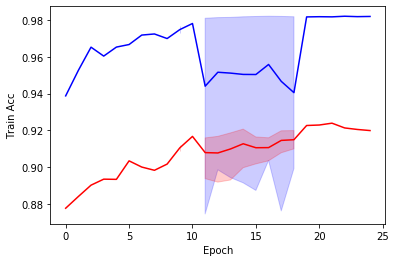

In [72]:
log = pd.read_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv')
sns.lineplot(x=log['Epoch'], y=log['Valid Acc'], color='blue')
sns.lineplot(x=log['Epoch'], y=log['Train Acc'], color='red')
#sns.lineplot(x=log['Epoch'], y=log['Recall'], color='green')
plt.show()

In [44]:
# --- Model --- Stage 2

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=2, min_lr=1e-10, verbose=True)

In [45]:
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 10/36
----------



train Loss: 0.2037 Acc: 0.9121



val Loss: 0.1140 Acc: 0.9768
564
recall: grapheme 0.912878787878788, vowel 0.9233766233766233, consonant 0.9939393939393939, total 0.9357683982683982
valid recall score is 0.936
Epoch 11/36
----------


/home/ryoooo1114/anaconda3/envs/analysis/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



train Loss: 0.1895 Acc: 0.9167



val Loss: 0.1137 Acc: 0.9781
564
recall: grapheme 0.9651162790697675, vowel 0.890909090909091, consonant 1.0, total 0.9552854122621565
valid recall score is 0.955
Epoch 12/36
----------



train Loss: 0.1776 Acc: 0.9141



val Loss: 0.1253 Acc: 0.9765
564
recall: grapheme 0.9651162790697675, vowel 0.8779220779220779, consonant 0.9939393939393939, total 0.9505235075002516
valid recall score is 0.951
Early stopping counter: 1
Epoch 13/36
----------



train Loss: 0.1599 Acc: 0.9167



val Loss: 0.1349 Acc: 0.9750
564
recall: grapheme 0.9767441860465116, vowel 0.890909090909091, consonant 1.0, total 0.9610993657505286
valid recall score is 0.961
Early stopping counter: 2
Epoch 14/36
----------



train Loss: 0.1781 Acc: 0.9180



val Loss: 0.1246 Acc: 0.9777
Epoch     5: reducing learning rate of group 0 to 3.5000e-04.
564
recall: grapheme 0.9573643410852715, vowel 0.890909090909091, consonant 1.0, total 0.9514094432699085
valid recall score is 0.951
Early stopping counter: 3
Epoch 15/36
----------



train Loss: 0.1682 Acc: 0.9207



val Loss: 0.1231 Acc: 0.9781
564
recall: grapheme 0.9457364341085273, vowel 0.890909090909091, consonant 1.0, total 0.9455954897815364
valid recall score is 0.946
Early stopping counter: 4
Epoch 16/36
----------
Early Stopped since loss have not decreased for 4 epoch.
Training complete in 272m 56s
Best val Acc: 0.978109


In [58]:
# --- Model --- Stage 3

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-10, verbose=True)

In [78]:
PATIAENCE = 6
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 16/36
----------



train Loss: 0.1640 Acc: 0.9173



val Loss: 0.1078 Acc: 0.9818
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Epoch 17/36
----------



train Loss: 0.1425 Acc: 0.9162



val Loss: 0.1063 Acc: 0.9820
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 1
Epoch 18/36
----------



train Loss: 0.1525 Acc: 0.9211



val Loss: 0.1050 Acc: 0.9820
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 2
Epoch 19/36
----------



train Loss: 0.1448 Acc: 0.9171



val Loss: 0.1068 Acc: 0.9820
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 3
Epoch 20/36
----------



train Loss: 0.1246 Acc: 0.9108



val Loss: 0.1091 Acc: 0.9820
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 0.9939393939393939, total 0.9710223268627074
valid recall score is 0.971
Early stopping counter: 4
Epoch 21/36
----------



train Loss: 0.1522 Acc: 0.9215



val Loss: 0.1100 Acc: 0.9820
Epoch    16: reducing learning rate of group 0 to 3.1250e-06.
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 5
Epoch 22/36
----------



train Loss: 0.1464 Acc: 0.9178



val Loss: 0.1071 Acc: 0.9819
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 6
Epoch 23/36
----------
Early Stopped since loss have not decreased for 6 epoch.
Training complete in 318m 16s
Best val Acc: 0.000000


In [65]:
# --- Model --- Stage 4

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.000025)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-10, verbose=True)

In [66]:
PATIAENCE = 6
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,best_epoch, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 15/36
----------



train Loss: 0.1683 Acc: 0.9135



val Loss: 0.1071 Acc: 0.9819
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Epoch 16/36
----------



train Loss: 0.1552 Acc: 0.9124



val Loss: 0.1081 Acc: 0.9821
564
recall: grapheme 0.9651162790697675, vowel 0.9681818181818183, consonant 1.0, total 0.9746035940803384
valid recall score is 0.975
Early stopping counter: 1
Epoch 17/36
----------



train Loss: 0.1578 Acc: 0.9197



val Loss: 0.1093 Acc: 0.9820
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 2
Epoch 18/36
----------



train Loss: 0.1414 Acc: 0.9199



val Loss: 0.1067 Acc: 0.9818
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Epoch 19/36
----------



train Loss: 0.1674 Acc: 0.9226



val Loss: 0.1093 Acc: 0.9817
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 1
Epoch 20/36
----------



train Loss: 0.1604 Acc: 0.9229



val Loss: 0.1093 Acc: 0.9818
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 2
Epoch 21/36
----------



train Loss: 0.1623 Acc: 0.9239



val Loss: 0.1079 Acc: 0.9817
Epoch     7: reducing learning rate of group 0 to 1.2500e-05.
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 0.9939393939393939, total 0.9710223268627074
valid recall score is 0.971
Early stopping counter: 3
Epoch 22/36
----------



train Loss: 0.1577 Acc: 0.9213



val Loss: 0.1082 Acc: 0.9821
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 4
Epoch 23/36
----------



train Loss: 0.1638 Acc: 0.9205



val Loss: 0.1107 Acc: 0.9818
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 5
Epoch 24/36
----------



train Loss: 0.1666 Acc: 0.9199



val Loss: 0.1109 Acc: 0.9819
Epoch    10: reducing learning rate of group 0 to 6.2500e-06.
564
recall: grapheme 0.9651162790697675, vowel 0.9599173553719008, consonant 1.0, total 0.972537478377859
valid recall score is 0.973
Early stopping counter: 6
Epoch 25/36
----------
Early Stopped since loss have not decreased for 6 epoch.
Training complete in 455m 29s
Best val Acc: 0.982059


# Evaluation

In [47]:
def predict(model, dataloaders, phase, device):
    model.eval()
    output_list = []
    label_list = []
    with torch.no_grad():
        if phase == 'test':
            for i, inputs in enumerate(tqdm(dataloaders)):
                
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, pred0 = torch.max(outputs[0], 1)
                _, pred1 = torch.max(outputs[1], 1)
                _, pred2 = torch.max(outputs[2], 1)
                preds = (pred0, pred1, pred2)
                output_list.append(preds)
            return output_list
        elif phase == 'val':
            for i, (inputs, labels) in enumerate(tqdm(dataloaders)):
                
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, pred0 = torch.max(outputs[0], 1)
                _, pred1 = torch.max(outputs[1], 1)
                _, pred2 = torch.max(outputs[2], 1)
                preds = (pred0, pred1, pred2)
                output_list.append(preds)
                label_list.append(labels.transpose(1,0))
            return output_list, label_list

In [81]:
save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch+1)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

<All keys matched successfully>

In [82]:
# --- Prediction ---
data_type = 'val'
valid_preds_list = []
print('valid_dataset', len(valid_dataset))
valid_preds_list, valid_label_list = predict(model_ft, valid_loader, data_type, DEVICE)
gc.collect()

valid_dataset 20084


5430

In [83]:
# Each test_preds indicates the prediction outputs of different batch
p0 = np.concatenate([valid_preds[0].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
p1 = np.concatenate([valid_preds[1].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
p2 = np.concatenate([valid_preds[2].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

a0 = np.concatenate([valid_label[0].cpu().numpy() for valid_label in valid_label_list], axis=0)
a1 = np.concatenate([valid_label[1].cpu().numpy() for valid_label in valid_label_list], axis=0)
a2 = np.concatenate([valid_label[2].cpu().numpy() for valid_label in valid_label_list], axis=0)
print('a0', a0.shape, 'a1', a1.shape, 'a2', a2.shape)

pred_labels = [p0, p1, p2]
y = [a0, a1, a2]
macro_recall(pred_labels, y, n_grapheme=168, n_vowel=11, n_consonant=7)
#fold 1 Stage-1 CV :0.9659313780016296 --> Stage-2 0.9666139805270331
#fold 2 Stage-1 CV :0.9698549400969805 --> Stage 2 0.9743222464903162

p0 (20084,) p1 (20084,) p2 (20084,)
a0 (20084,) a1 (20084,) a2 (20084,)
recall: grapheme 0.9655606691162243, vowel 0.9886849875898626, consonant 0.9802793245519252, total 0.9750214125935591


0.9750214125935591

# Inference

In [ ]:
# --- Prediction ---
data_type = 'test'
test_preds_list = []
for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        DATADIR, FEATHERDIR, data_type = data_type, submission=True, indices=indices)
    n_dataset = len(test_images)
    print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)
    test_dataset = BengaliAIDataset(
    test_images, None,
    transform=data_transforms[data_type])
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKER)
    
    test_preds_list = predict(model_ft, test_loader, data_type,DEVICE)
    del test_images
    gc.collect()
    if DEBUG:
        break

In [ ]:
# Each test_preds indicates the prediction outputs of different batch
p0 = np.concatenate([test_preds[0].cpu().numpy() for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1].cpu().numpy() for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2].cpu().numpy() for test_preds in test_preds_list], axis=0)
print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    row_id += [f'Test_{i}_grapheme_root', f'Test_{i}_vowel_diacritic',
               f'Test_{i}_consonant_diacritic']
    target += [p0[i], p1[i], p2[i]]
pred_df = pd.DataFrame({'row_id': row_id, 'target': target})

In [ ]:
pred_df.to_csv('submission.csv', index=False)